# Introduction

In this notebook, I want to experiment with the problem using the provided sample driving data. The aim is to create a working solution that is able to predict the correct steering angle just by using three training examples. Using so
small a training set means that the model should quickly overfit if it is working properly, which should indicate that it should be ok to use the model in further experiments. The idea for this approach came from Paul Heraty's cheatsheet (https://carnd-forums.udacity.com/questions/26214464/behavioral-cloning-cheatsheet). 

Specifically, I want to 
1. Access the driving data provided by Udacity
1. Pick three representative training examples from the data
1. Setup a LeNet-like model using Keras
1. Train the model and see if it can perfectly learn the test data (i.e. overfit it)

## Step 1: Access the driving data


As a preparation step, I read the data in the driving_log.csv with Pandas and print some statistics.

          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


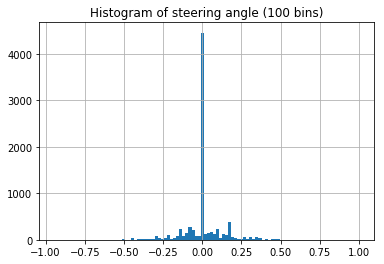

In [9]:
%matplotlib inline  

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('data/driving_log.csv')
print(df.describe())
df['steering'].hist(bins=100)
plt.title('Histogram of steering angle (100 bins)')

Seems that we are mostly steering straight here.

## Step 2: Picking the training images

Now I need to pick three images from the sample driving data that correspond to steering left, right and straight. This set of images should be enough to see that the model is able to learn the differences between the images if it can predict the different steering angles correctly.

Let's first get the indices
of records where steering angle is hard left (< -0.5).

In [2]:


df[df['steering'] < -0.5].index

Int64Index([1181, 1182, 1183, 3266, 3267, 3268, 3438, 3439, 3440, 3453, 4042,
            4043, 4044, 4340, 4341, 4342, 4350, 4351, 4352, 4521, 4522, 7260,
            7261, 7820],
           dtype='int64')

By trial and error, I ended up picking index 4341 where the image matches the left turn nicely.

Steering angle -0.505992


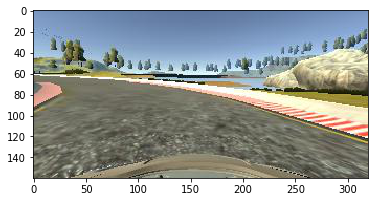

In [3]:
import os
from PIL import Image

def get_record_and_image(index):
    record = df.iloc[index]
    path = os.path.join('data', record.center)
    return record, Image.open(path)

left_record, left_image = get_record_and_image(4341)
print('Steering angle {}'.format(left_record.steering))
plt.imshow(left_image)

Let's do the same with the hard right turn (steering angle > 0.5).

In [4]:
df[df['steering'] > 0.5].index


Int64Index([  55,   56, 1175, 1176, 1186, 1187, 1197, 3357, 3358, 3359, 3434,
            3598, 3636, 3761, 4036, 4037, 4038, 4443, 4453, 4462],
           dtype='int64')

Again, after some peeking of the images, the index 3357 looks fine.

Steering angle 0.5114809


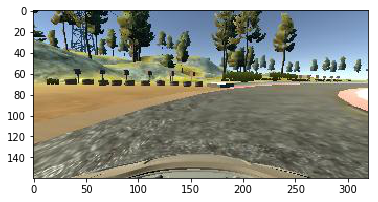

In [5]:
right_record, right_image = get_record_and_image(3357)
print('Steering angle {}'.format(right_record.steering))
plt.imshow(right_image)

Now I need to pick an record for driving straight. There should be plenty of choices to pick from, so some random exploration of the choices is probably the best way to find one that looks ok.

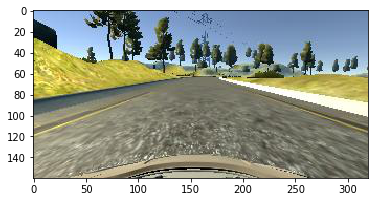

In [6]:
# I used this code to pick random images until I found one I liked
#index = df[(df['steering'] > -0.1) & (df['steering'] < 0.1)].sample(n=1).iloc[0].name
#print('Index', index)

straight_record, straight_image = get_record_and_image(796)
plt.imshow(straight_image)

## Step 3: Setup the model

Having selected the training examples, I next need to create a DNN model to train. I first thought about starting with the Nvidia pipeline (http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) but I started to wonder how a bit simpler network like the LeNet would work. The input is likely less complex here than in the Nvidia self-driving car case, with the constant lightning and road color etc. 

So, let's setup a modified version of the LeNet that can take the 320x160 images as input and outputs a single number between -1 and 1. Because the image resolution is so much higher than in the original LeNet it probably makes sense to use striding in the convolution layers to reduce the dimensionality. Let's try (10, 10) stride for the first convolution layer followed To get the [-1, 1] range for the output, tanh activation function seems to be a good choice.

In [145]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

model = Sequential()
model.add(Convolution2D(6, 5, 5, border_mode='valid', subsample=(5, 5), input_shape=(160, 320, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(16, 5, 5, border_mode='valid', subsample=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('tanh'))

Lets check the dimensions of the network layers.

In [146]:
for n, layer in enumerate(model.layers, 1):
    print('Layer {:2} {:16} input shape {} output shape {}'.format(n, layer.name, layer.input_shape, layer.output_shape))

Layer  1 convolution2d_44 input shape (None, 160, 320, 3) output shape (None, 32, 64, 6)
Layer  2 activation_106   input shape (None, 32, 64, 6) output shape (None, 32, 64, 6)
Layer  3 maxpooling2d_41  input shape (None, 32, 64, 6) output shape (None, 16, 32, 6)
Layer  4 convolution2d_45 input shape (None, 16, 32, 6) output shape (None, 6, 14, 16)
Layer  5 activation_107   input shape (None, 6, 14, 16) output shape (None, 6, 14, 16)
Layer  6 maxpooling2d_42  input shape (None, 6, 14, 16) output shape (None, 3, 7, 16)
Layer  7 flatten_23       input shape (None, 3, 7, 16) output shape (None, 336)
Layer  8 dense_64         input shape (None, 336) output shape (None, 120)
Layer  9 activation_108   input shape (None, 120) output shape (None, 120)
Layer 10 dense_65         input shape (None, 120) output shape (None, 84)
Layer 11 activation_109   input shape (None, 84) output shape (None, 84)
Layer 12 dense_66         input shape (None, 84) output shape (None, 1)
Layer 13 activation_110   in

Now I need to massage the images and corresponding steering angles to form that is usable in model training. 

In [149]:
X_train = [np.array(image) for image in [left_image, right_image, straight_image]]
X_min = np.min(X_train)
X_max = np.max(X_train)
X_normalized = (X_train - X_min) / (X_max - X_min) - 0.5
y_train = np.array([record['steering'] for record in [left_record, right_record, straight_record]])

In [150]:
from random import randrange

def generator():
    while 1:
        i = randrange(3)
        # Create a one item batch by taking a slice
        yield X_normalized[i:i+1], y_train[i:i+1]

model.compile('adam', 'mse')
history = model.fit_generator(generator(), samples_per_epoch=1000, validation_data=(X_normalized, y_train), nb_epoch=10, verbose=2)

Epoch 1/10
13s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
11s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
11s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
11s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
11s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
12s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
12s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
12s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
11s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
11s - loss: 0.0000e+00 - val_loss: 0.0000e+00


Training hits zero validation loss after epoch 5, i.e., it should have learned the data perfectly. Lets see how well the model predicts.

In [151]:
for X, y in zip(X_expand, y_train):
    print('Actual steering angle {} model prediction {}'.format(y, model.predict(X)[0][0]))

Actual steering angle -0.505992 model prediction -0.5059919953346252
Actual steering angle 0.5114809 model prediction 0.5114809274673462
Actual steering angle 0.0 model prediction 0.0


The predictions are perfect as they should be. The model seems to be able to learn at least some relevant features from the images and is therefore suitable for further testing.